# Correspondence between Hi-C subcompartments and chromHMM segments

I recently had a thought about a suggestion one of the other bioinformaticians made when I was presenting my master's thesis in the bioinformatics JC. They were suggeting doing the segmentation also with chromHMM or a similar HMM segmentation tool and look at the correspondence of it with the Hi-C subcompartments. So I found that this would be a wonderful way to make our point stronger in case somebody complains about this and performed a segmentation as described (doi:10.1038/nprot.2017.124). In particular I used, H3K4me1 and 3, H3K27ac and me3 and H3K36me3 from ENCODE and H3K9me3 WT generated by us (including inputs) in addition to DHS-seq, Repli-seq of early and late S phase and WT PRO-seq data as input for the chromHMM software.

# Assessing coverage of Hi-C subcompartments and chromHMM segments

In [1]:
import numpy as np
import matplotlib.gridspec as gs
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import scipy.stats as scistats
from scipy.sparse import csr_matrix, triu, lil_matrix
from scipy.cluster import hierarchy
import itertools as it
import scipy.linalg as scilin
import tables
import sys
import warnings
import logging
import os

redmap = clr.LinearSegmentedColormap.from_list('redmap', ['White', 'Red'], N = 256)
wbg = clr.LinearSegmentedColormap.from_list('wbg', ['White', 'powderblue', 'c', 'seagreen'], N = 256)


def toString(s):
    """
    This takes care of python2/3 differences
    """
    if isinstance(s, str):
        return s

    if isinstance(s, bytes):  # or isinstance(s, np.bytes_):
        if sys.version_info[0] == 2:
            return str(s)
        return s.decode('ascii')

    if isinstance(s, list):
        return [toString(x) for x in s]

    if isinstance(s, np.ndarray):
        return s.astype(str)

    return s


def loadH5(filename, includechroms=None, csr=True, returnintervals = False, dtype = int):
    '''
    loadH5(filename, includechroms=None, csr=True, returnintervals = False)

    loads an *.h5 hic matrix as created by hicexplorer

    :param filename:        name of the *.h5 file containing the matrix
    :param includechroms:   list of chromosomes to include in the returned objects
                            if not given all chromosomes in the *.h5 file are included
    :param csr:             if True returns a csr_matrix object else a full numpy.array
    :param returnintervals: if True also returns the intervals read

    :return:                csr_matrix containing the data in the matrix
    '''
    with tables.open_file(filename) as f:
        parts = {}
        try:
            for matrix_part in ('data', 'indices', 'indptr', 'shape'):
                parts[matrix_part] = getattr(f.root.matrix, matrix_part).read()
        except Exception:
            logging.info('No h5 file. Please check parameters concerning the file type!')
            exit(1)

        matrix = csr_matrix(tuple([parts['data'], parts['indices'], parts['indptr']]),
                            shape=parts['shape'], dtype=dtype)

        intervals = {}
        for interval_part in ('chr_list', 'start_list', 'end_list', 'extra_list'):
            if toString(interval_part) == toString('chr_list'):
                chrom_list = getattr(f.root.intervals, interval_part).read()
                intervals[interval_part] = toString(chrom_list)
            else:
                intervals[interval_part] = getattr(f.root.intervals, interval_part).read()

        cut_intervals = list(
            zip(intervals['chr_list'], intervals['start_list'], intervals['end_list'], intervals['extra_list']))

        assert len(cut_intervals) == matrix.shape[0], \
            "Error loading matrix. Length of bin intervals ({}) is different than the " \
            "size of the matrix ({})".format(len(cut_intervals), matrix.shape[0])

        # compute index array and chromosome list
        inds, chr_list, chroms = [], [], set()
        for i, (chr, start, end, extra) in enumerate(cut_intervals):
            if chr not in chroms:
                chroms.add(chr)
                inds.append(i)
                chr_list.append(chr)

        # if includechroms is given we filter the output for the chromosomes listed
        # and recompute indices of chromosome boundaries in the resulting matrix
        if includechroms:
            includechroms = set(includechroms)
            filterinds, filterchrs = [], []
            for i, chr in zip(range(len(inds)), chr_list):
                if chr in includechroms:
                    filterinds.append([inds[i], inds[i + 1] if i + 1 != len(inds) else matrix.shape[0]])
                    filterchrs.append(chr)

            matrixinds = np.zeros(shape=matrix.shape[0], dtype=bool)
            ncuts, tmpe = [], 0
            for s, e in filterinds:
                matrixinds[s: e] = True

                if s == tmpe:
                    ncuts.append(s)
                    tmpe = e

                else:
                    ncuts.append(tmpe)
                    tmpe = e - s + tmpe

            if csr:
                matrix = matrix[matrixinds, :][:, matrixinds]

            else:
                matrix = matrix.toarray()
                xi, yi = np.triu_indices(matrix.shape[0], k=1)
                matrix[yi, xi] = matrix[xi, yi]

            inds = ncuts

            chr_list = filterchrs

    if not includechroms and not csr:
        x = matrix.toarray()
        xi, yi = np.triu_indices(x.shape[0], k=1)
        x[yi, xi] = x[xi, yi]
        matrix = x

    if returnintervals:
        return matrix, np.array(inds), np.array(chr_list), intervals

    else:
        return matrix, np.array(inds), np.array(chr_list)


def plotmatrix(mat, cmap, vmin=None, vmax=None, ax=None, xticks=None, yticks=None,
               xchroms=None, ychroms=None, title=None, remove=None, aspect = 'equal'):
    '''
    plotmatrix(mat, cmap, vmin = None, vmax = None, ax = None, xticks = None, yticks = None,
               xchroms = None, ychroms = None, title = None, remove = None)

    function to visualize a given contact matrix

    :param mat:         matrix to visualize
    :param cmap:        colormap to use
    :param vmin:        minimum value for colormap
    :param vmax:        maximum value for colormap
    :param ax:          matplotlib.Axes object to plot the heatmap to
                        if not given it is created anew
    :param xticks:      position of xticks (chromosome borders) if None xticks are disabled
    :param yticks:      position of yticks (chromosome borders) if None yticks are disabled
    :param xchroms:     names of the chromosomes on the x-axis
    :param ychroms:     names of the chromosomes on the y-axis
    :param title:       title of the plot
    :param remove:      expects a dictionary of the format {'row': numpy.array, 'col': numpy.array}
                        where the arrays hold indices of rows and columns that should be removed
                        before plotting
    :param aspect:      either equal (default) or auto, see matplotlib.pyplot.imshow for details
                        results in a higher resolution of the plot

    :return:            matplotlib.Axes and matplotlib.image objects
    '''

    if not ax:
        fig, ax = plt.subplots()

    # generating matrix with all zero diagonal for and
    # ad-hoc visualization
    zerodiag = mat.copy()
    np.fill_diagonal(zerodiag, 0)

    if not vmin:
        vmin = 0

    if not vmax:
        vmax = zerodiag.max()

    if remove:
        mat = mat.copy()

        # generating boolean indices
        remrows = np.ones(shape=mat.shape[0], dtype=bool)
        remcols = np.ones(shape=mat.shape[1], dtype=bool)

        for rowind in remove['row']:
            remrows[rowind] = False

        for colind in remove['col']:
            remcols[colind] = False

        mat = mat[remrows, :][:, remcols]

    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, aspect = aspect)

    if title:
        ax.set_title(title)

    # deactivating default ticks
    ax.tick_params(axis='both', which='both', bottom=False, left=False,
                   labelbottom=False, labelleft=False)

    if np.any(xticks):
        ax.tick_params(axis='x', which='major', top=True, direction='in', length=2)
        ax.tick_params(axis='x', which='minor', labeltop=True)
        ax.set_xticks([i for i in xticks] + [mat.shape[1]])

    if xchroms:
        xlabelpos = []
        for i in range(len(xticks)):
            lp = (xticks[i + 1] + xticks[i]) / 2 if i + 1 != len(xticks) else (mat.shape[1] + xticks[i]) / 2
            xlabelpos.append(lp)

        ax.set_xticks(xlabelpos, minor=True)
        ax.set_xticklabels(xchroms, minor=True, fontsize=10)

    if np.any(yticks):
        ax.tick_params(axis='y', which='major', left=True, direction='in', length=2)
        ax.tick_params(axis='y', which='minor', labelleft=True)
        ax.set_yticks([i for i in yticks] + [mat.shape[0]])

    if ychroms:
        ylabelpos = []
        for i in range(len(yticks)):
            lp = (yticks[i + 1] + yticks[i]) / 2 if i + 1 != len(yticks) else (mat.shape[0] + yticks[i]) / 2
            ylabelpos.append(lp)

        ax.set_yticks(ylabelpos, minor=True)
        ax.set_yticklabels(ychroms, minor=True, fontsize=10)

    return ax, im


def readGeneTrack(bedfile, chr, chrbins, resolution):
    '''
    reads in a genetrack file in BED format and returns a numpy.array
    with 1 if a gene is in a given bin or 0 else. This function assumes
    that the bedfile is sorted by chromosome and startposition

    :param bedfile:     BED file holding gene annotation for the given genome
    :param chr:         chromosome to retrieve the genetrack for
    :param chrbins:     number of bins the chromosome is divided in
    :param resolution:  size of the bins used to construct the contact matrix

    :return:            numpy.array holding genetrack information
    '''
    # initializing return array
    genetrack = np.zeros(shape = chrbins, dtype = int)

    # reading geneTrack
    with open(bedfile, 'r') as bed:
        brake = False
        for gene in bed:
            c, start, end, name = gene.rstrip().split('\t')[:4]

            # if we are not on the right chromosome
            if not c == chr:
                # if we already parsed the desired chromosome
                if brake:
                    # we break out of the loop
                    break

                # if we not yet parsed the desired chromosome
                else:
                    # we continue
                    continue

            else:
                # computing the bins to set value 1 to
                start, end = [int(pos) for pos in [start, end]]
                i1, i2 = start//resolution, end//resolution + 1
                genetrack[i1: i2] = 1

                if not brake:
                    brake = True

    return genetrack


def correlateEigenvectorWithGeneTrack(eigenvector, genetrack):
    '''
    computed the correlation between an eigenvector of a given chromosome and
    its gene track. If the correlation is negative the sign of the eigenvector values
    is flipped.

    :param eigenvector: first eigenvector of the correlation matrix
    :param genetrack:   numpy.array holding a 1 if there is a gene in the bin and 0 otherwise

    :return:            eigenvector with flipped signs if correlation between values and genetrack
                        is negative otherwise same as given
    '''
    correlation, pval = scistats.pearsonr(eigenvector, genetrack)

    return eigenvector if correlation >= 0 else np.negative(eigenvector)



def clusterEnrichment(clusters, genebed, indarr, gwmatdim, chrlist, remrows, remcols, chrlens, intradir, resolution):
    '''
    uses the clusterassignment for each bin on each chromosome and computes the
    percentage of clusters contained in compartments A and B genomewide
    for even and odd clustering results.


    :param clusters:    dictionary with keys = ['even', 'odd'] containing the clustering assignments
    :param genebed:     bedfile containing annotated genes
    :param indarr:      indexarry of the original genomewide contact matrix
    :param gwmatdim:    dimension of the genomewide contact matrix used to construct Cij (i.e. without X)
    :param chrlist:     list of chromosomes used in clustering (without X)
    :param remrows:     dictionary with keys = ['even', 'odd'] containing the removed rows for each clustering
    :param remcols:     dictionary with keys = ['even', 'odd'] containing the removed columns for each clustering
    :param chrlens:     dictionary containing a map of chromosome names to their lengths
    :param intradir:    directory containing the intrachromosomal contact matrices norm vectors and expected vectors
                        corresponding to the norm

    :return:            dictionary of dictionaries of numpy.arrays
                        containing enrichments in clusters per compartment for each clustering
    '''
    # generating indices for rowinds in clusterings
    evenpair, oddpair = [(['chr' + str(i) for i in range(i, 2 * k + i, 2)],
                          [[i, i + 1] for i in range(k)]) for k, i in zip((9, 10), (2, 1))]

    evenchroms = {k: i for k, i in zip(*evenpair)}
    oddchroms = {k: i for k, i in zip(*oddpair)}

    # initializing return dictionary
    compenrich = {'even': None, 'odd': None}
    for key, even in zip(['even', 'odd'], [True, False]):
        rowinds, colinds, (nr, nc) = updateindex(indarr, gwmatdim, chrlist,
                                                 remrows[key], remcols[key],
                                                 even = even, return_original = True)

        # specifying even or odd chromosomes
        chroms = evenpair[0] if even else oddpair[0]
        compenrich[key] = {k: np.zeros(shape = len(np.unique(clusters[key]))) for k in 'AB'}
        for chr in chroms:
            # reading in respective files
            matrixfile = '_'.join([chr, str(resolution//1000)]) + 'kb.RAWobserved'
            cmat = readSparseMatrixFileIntra(os.path.join(intradir, 'intra', matrixfile), chrlens[chr], resolution)
            normvec = readNormVector(os.path.join(intradir, 'norms', matrixfile.replace('RAWobserved', 'KRnorm')))
            expectvec = np.loadtxt(os.path.join(intradir, 'expect', matrixfile.replace('RAWobserved', 'KRexpected')))
            gtrack = readGeneTrack(genebed, chr, chrlens[chr], resolution)

            # computing E/O matrix
            normcmat = normalizeMatrixIntra(cmat, normvec)
            eomat = computeEO(normcmat, expectvec)

            # computing pearson correlation matrix
            # ignoring divide by 0 warning
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                pcorrmat = np.corrcoef(eomat)

            # making sure all values are well defined
            pcorrmat[np.isnan(pcorrmat)] = 0.
            pcorrmat[np.isinf(pcorrmat)] = 0.

            # computing covariance matrix
            covmat = np.cov(pcorrmat)

            # making sure all values are well defined
            covmat[np.isnan(covmat)] = 0.
            covmat[np.isinf(covmat)] = 0.

            # computing eigenvalues and eigenvectors
            lambdas, eigvs = scilin.eigh(covmat)

            # correlating first eigenvector with genetrack
            # to flip signs if correlation is negative
            # positive eigenvalues correspond to compartment A
            # negative eigenvalues correspond to compartment B
            compartments = correlateEigenvectorWithGeneTrack(eigvs[:, -1], gtrack)

            # resizing the clustering assignment for the respective chromosome
            start, stop = evenchroms[chr] if even else oddchroms[chr]
            binassigns = getBinAssignments(nr, clusters[key],
                                           startbin = rowinds[start],
                                           stopbin = rowinds[stop] if stop != len(rowinds) else nr,
                                           rembins = remrows[key])

            # computing cluster enrichment per compartment
            for c, e in zip(binassigns, compartments):
                if c != -1:
                    if e > 0:
                        compenrich[key]['A'][c] += 1

                    elif e < 0:
                        compenrich[key]['B'][c] += 1


    return compenrich


def plotheatmap(mat, ax, cmap, xlabels, ylabels, vmin=0.5, vmax=1.5,
                reorder=True, cbar=True, cbarticks=None, pvals=None, xrotation=0,
                yorder=None, xorder=None):
    '''
    generates a heatmap of the given matrix, in the given matplotlib.Axes object
    with x and y axis annotated by with corresponding labels

    :param mat:         matrix containing the values to plot
    :param ax:          matplotlib.Axes object to generate the plot in
    :param cmap:        colormap to use for the heatmap
    :param xlabels:     labels of the xticks
    :param ylabels:     labels of the yticks
    :param vmin:        minimum value of the colormap
    :param vmax:        maximum value of the colormap
    :param reorder:     if True, single link hierarchical clustering is used to reorder
                        both axes
    :param cbar:        if True, plots colorbar
    :param cbarticks:   positions of ticks on colorbar
    :param pvals:       if given, pvals are plotted beneath the value in the heatmap
    :param xrotation:   specifies the rotation angle of the xlabels
    :param xorder:      specifies order of x data, usage exclusively in conjunction with yorder, overrides reorder
    :param yorder:      specifies order of y data, usage exclusively in conjunction with xorder, overrides reorder

    :return:            None
    '''
    if yorder and xorder:
        mat = mat[yorder, :][:, xorder]
        xlabels = np.array(xlabels)[xorder]
        ylabels = np.array(ylabels)[yorder]

    elif reorder:
        Zy = hierarchy.single(mat)
        yordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Zy, mat))

        Zx = hierarchy.single(mat.T)
        xordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Zx, mat.T))
        mat = mat[yordering, :][:, xordering]
        xlabels = np.array(xlabels)[xordering]
        ylabels = np.array(ylabels)[yordering]

    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels, rotation=xrotation, ha='center' if not xrotation else 'left')
    ax.set_yticklabels(ylabels, va='center', rotation=90)
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)

    # annotating individual cells
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            celltext = str(np.round(mat[i, j], 2)) if not type(pvals) == np.ndarray \
                else '%.02f\n(%.0e)' % (np.round(mat[i, j], 2), pvals[i, j])
            text = ax.text(j, i, celltext, ha='center',
                           va='center', color='black')

    # plot colorbar
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax, ticks=cbarticks)
        cbar.ax.tick_params(axis='y', direction='in')


def clusterCoverage(clusters, clustermap, resolution, ax, labels):
    '''
    generates a bargraph displaying the coverage of each cluster
    across the genome in basepairs.

    :param clusters:    dictionary containing cluster assignments of even and odd chromosome bins
    :param clustermap:  one to one map of odd clusters to even clusters
    :param resolution:  size of each bin corresponding to a cluster assignment
    :param ax:          matplotlib.Axes object to generate the plot in
    :param labels:      labels corresponding to clusters on odd chromosomes

    :return:            None
    '''
    # initializing variables
    oddclusters = np.unique(clusters['odd'])
    coverage = np.zeros(shape = len(oddclusters))

    # computing coverage per cluster
    for oddc in oddclusters:
        odd = np.sum(clusters['odd'] == oddc)
        even = np.sum(clusters['even'] == clustermap[oddc])

        # computing coverage in Mbp
        coverage[oddc] = (even + odd) * resolution / 1000000

    # reordering coverage and labels
    labels = np.array(labels)
    sortinds = np.argsort(labels)
    labels.sort()
    coverage = coverage[sortinds]

    # generating barplot
    ax.bar(np.arange(1, len(coverage) + 1), coverage, align = 'center', color = 'dimgrey',
           tick_label = labels, linewidth = 0.5, edgecolor = 'black')
    
    for i, cov in enumerate(coverage):
        ax.text(i + 1, cov, str(cov), va = 'bottom', ha = 'center')

    ax.set_ylabel('Total Coverage [Mbp]')


def meanClusterSize(clusters, clustermap, resolution, ax, labels):
    '''
    generates a bargraph displaying the mean size of a given cluster
    in basepairs. Median is displayed as line in bars

    :param clusters:    dictionary containing cluster assignments of even and odd chromosome bins
    :param clustermap:  one to one map of odd clusters to even clusters
    :param resolution:  size of each bin corresponding to each cluster assignment
    :param ax:          matplotlib.Axes object to generate the plot in
    :param labels:      labels corresponding to clusters on odd chromosomes

    :return:            None
    '''
    # initializing variables
    oddclusters = np.unique(clusters['odd'])
    meansize = np.zeros(shape=len(oddclusters))
    mediansize = np.zeros(shape=len(oddclusters))

    # compute number of cluster instances for each cluster
    for oddc in oddclusters:
        oddcbins = np.where(clusters['odd'] == oddc)[0]
        evencbins = np.where(clusters['even'] == clustermap[oddc])[0]

        # computing cluster lengths
        oddclens = np.array([len(s) for s in np.split(oddcbins, np.where(np.diff(oddcbins) != 1)[0] + 1)])
        evenclens = np.array([len(s) for s in np.split(evencbins, np.where(np.diff(evencbins) != 1)[0] + 1)])

        # computing meansize and median size in Kbp
        clustersizes = np.concatenate([oddclens, evenclens])
        meansize[oddc] = clustersizes.mean() * resolution / 1000
        mediansize[oddc] = np.median(clustersizes) * resolution / 1000

    # reordering coverage and labels
    labels = np.array(labels)
    sortinds = np.argsort(labels)
    labels.sort()
    meansize = meansize[sortinds]
    mediansize = mediansize[sortinds]

    # generating barplot of means
    barwidth = 0.8
    ax.bar(np.arange(1, len(meansize) + 1), meansize, align = 'center', color = 'dimgrey',
           tick_label = labels, linewidth = 0.5, edgecolor = 'black', width = barwidth)

    ax.set_ylabel('Mean Size [Kbp]')
    
    for i, (mean, median) in enumerate(zip(meansize, mediansize)):
        ax.text(i + 1, mean, '$\mu$ = {0:.2f}\nm = {1}'.format(mean, median), ha = 'center', va = 'bottom')

    # displaying median in bars
    for i in range(len(mediansize)):
        ax.plot((i + 1 - 0.25, i + 1 + 0.25), (mediansize[i], ) * 2, zorder = 2, linewidth = 2, color = 'black')


def chromosomeSubcompartments(indarr, gwmatdim, chrlist, remrows, remcols,
                              clusters, clustermap, ax, labels, cmap = wbg):
    '''
    computes the percentage cluster coverage of each chromosome in the genome
    involved in the clustering process

    :param indarr:      array holding indices for the genome wide contact matrix
                        as returned by constructGenomeWideContactMatrix
    :param gwmatdim:    dimension of the symmetric original gwmat
                        from which Cij is constructed (length of X needs to be subtracted
                        if not included)
    :param chrlist:     ordered list of chromosomes corresponding to indarr
    :param remrows:     indices of rows removed during construction of Cij
    :param remcols:     indices of columns removed during construction of Cij
    :param clusters:    clusterassignments for even and odd chromosomes
    :param clustermap:  map of odd clusterassignments to even clusterassignments
    :param ax:          matplotlib.Axes object to create the plots in
    :param labels:      labels corresponding to clusters on odd chromosomes

    :return:            None
    '''
    # generating true cluster order for plotting
    # and reordering labels
    labels = np.array(labels)
    sortinds = np.concatenate([np.argsort(labels), np.array([5])])
    labels.sort()
    labels = np.concatenate([labels, np.array(['UD'])])

    # constructing indices to access index array per chromosome
    evenpair, oddpair = [(['chr' + str(i) for i in range(i, 2 * k + i, 2)],
                          [[i, i + 1] for i in range(k)]) for k, i in zip((9, 10), (2, 1))]

    bininds = {k1: {k2: i for k2, i in zip(*pair)} for k1, pair in zip(['even', 'odd'], [evenpair, oddpair])}

    # initializing result matrix and corresponding indices for accessing it
    percentages = np.zeros(shape = (len(np.unique(clusters['odd'])) + 1, len(chrlist)))
    inds = {k: {'chr' + str(i + 1): i for i in range(j, 20 - j, 2)} for k, j in zip(['odd', 'even'], range(2))}

    for key, even in zip(['odd', 'even'], [False, True]):
        rowinds, colinds, (nr, nc) = updateindex(indarr, gwmatdim, chrlist, remrows[key],
                                                 remcols[key], even = even, return_original = True)

        for chr in bininds[key].keys():
            start, stop = bininds[key][chr]
            binassigns = getBinAssignments(nr, clusters[key],
                                           startbin = rowinds[start],
                                           stopbin = rowinds[stop] if stop != len(rowinds) else nr,
                                           rembins = remrows[key])

            # computing cluster coverage for respective chromosome
            arr = np.zeros(shape = len(np.unique(labels)))
            for c in np.unique(binassigns):
                if not even:
                    arr[c] = np.sum(binassigns == c)

                else:
                    # clustermap is to have the right corresponding cluster
                    # on even chromosomes as for odd chromosomes
                    arr[c] = np.sum(binassigns == clustermap[c])

            print(arr)
            percentages[:, inds[key][chr]] = arr[sortinds] / arr.sum() * 100

    im = ax.imshow(percentages, cmap = cmap, vmin = 0, vmax = 100)

    ax.set_xticks(np.arange(len(chrlist)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(chrlist)
    ax.set_yticklabels(labels, va = 'center')
    ax.tick_params(axis='x', bottom=False, left = False, labelbottom=False, labeltop=True)

    # annotating individual cells
    for i in range(len(labels)):
        for j in range(len(chrlist)):
            text = ax.text(j, i, np.round(percentages[i, j], 2), ha='center',
                           va='center', color='black')

    # plot colorbar
    cbar = ax.figure.colorbar(im, ax=ax, ticks = np.arange(0, 101, 10))
    cbar.ax.tick_params(axis='y', direction='in')


def readSignalTrack(signalfile, binsize, chrbins, chrlist):
    '''
    parses the given bedgraph file and returns a numpy array where each contained value
    corresponds to the number of counted reads in a bin of size binsize

    :param signalfile:  filename of the bedgraph
    :param binsize:     binsize used to generate the bedgraph
    :param chrbins:     dictionary holding the number of bins into which each chromosome is divided
                        this is to maintain congruency of arrays
    :param chrlist:     list of chromosomes to consider

    :return:            numpy.array of values per bin
    '''
    chrtracks = {k: np.zeros(shape = chrbins[k], dtype = int) for k in chrlist}
    with open(signalfile, 'r') as file:
        for line in file:
            line = line.rstrip().split('\t')

            try:
                start, stop, count = [int(i) for i in line[1:]]

            except ValueError:
                start, stop, count = [int(float(i)) for i in line[1:]]

            if line[0] in chrtracks:
                if not (stop - start)%binsize == 0:
                    repeat = 1
                else:
                    repeat = (stop - start)//binsize

                for i in range(repeat):
                    ind = (start + i * binsize)//binsize
                    chrtracks[line[0]][ind] = count

    # post processing arrays due to deeptools merging the last two bins
    for chr in chrlist:
        chrtracks[chr][[-2, -1]] = chrtracks[chr][-2]//2

    return np.concatenate([chrtracks[chr] for chr in chrlist])


def enrichSignal(signaltrack, clustertrack, undefined = True):
    '''
    computes enrichment factor for a given signaltrack for each cluster
    in the clustertrack. Enrichment is calculated by computing median signal value
    for each cluster and dividing it by the genomewide median (i.e. median of all bins)

    :param signaltrack:     numpy.array holding signal counts as returned by readSignalTrack
    :param clustertrack:    numpy.array holding the cluster assignments as returned by generateClusterTrack
    :param undefined:       if False, the function assumes all bins are assigned to a given cluster

    :return:                numpy.array with enrichment factor for each cluster
    '''
    # initializing variables
    gwmedian = np.median(signaltrack)
    clusters = np.unique(clustertrack)

    # initializing resultvariables
    enrichment = np.zeros(shape = len(clusters) - 1 if undefined else len(clusters))

    for c in clusters:
        if c == -1:
            continue

        else:
            # calculating enrichment
            enrichment[c] = np.median(signaltrack[clustertrack == c])/gwmedian

    return enrichment


def correlateSignal(signaltrack, clustertrack, undefined = True):
    '''
    computes the correlation between a given signaltrack and each cluster
    in the clustertrack. Correlation is inferred by calculating the spearman correlation
    between the binned signal track and a pseudo cluster track where bins belonging to
    the cluster of interest have 1 and -1 otherwise

    :param signaltrack:     numpy.array holding signal counts as returned by readSignalTrack
    :param clustertrack:    numpy.array holding the cluster assignments as returned by generateClusterTrack
    :param undefined:       if False, the function assumes all bins are assigned to a given cluster

    :return:                numpy.array with enrichment factor for each cluster
                            numpy.array with correlation for each cluster
                            numpy.array with correlation p-vals for each cluster
    '''
    # initializing variables
    clusters = np.unique(clustertrack)

    # initializing resultvariables
    correlation = np.zeros(shape = len(clusters) - 1 if undefined else len(clusters))
    corrpvals = np.zeros(shape = len(clusters) - 1 if undefined else len(clusters))
    # wstatistic = np.zeros(shape = len(clusters) - 1)
    # wpvals = np.zeros(shape = len(clusters) - 1)

    for c in clusters:
        if c == -1:
            continue

        else:
            # calculating correlation
            pseudoclusters = np.ones(shape = len(clustertrack), dtype = int)
            pseudoclusters[clustertrack != c] = -1
            correlation[c], corrpvals[c] = scistats.spearmanr(signaltrack, pseudoclusters)

            # perform wilcoxon rank-sum test
            # wstatistic[c], wpvals[c] = scistats.mannwhitneyu(signaltrack[clustertrack == c],
            #                                                 signaltrack[clustertrack != c],
            #                                                 alternative = 'two-sided')

    return correlation, corrpvals


def readSegmentation(segmentationfile, resolution, chrbins):
    '''
    reads a segmentation BED file and returns a genome-wide track with
    resolution binsize containing compartment assignments per bin and filling
    the rest with UD

    :param segmentationfile:    BEDfile containing the genome segmentation
    :param resolution:          resolution used to generate the annotation
    :param chrbins:             dictionary containing required number of bins per chromosome

    :return:                    genome-wide segmentation track
    '''

    chrtrack = {}
    prevstart = None
    prevend = 0
    prevchr = None
    with open(segmentationfile, 'r') as scfile:
        for line in scfile:
            chr, start, end, name = line.rstrip().split('\t')
            start = int(start)
            end = int(end)

            if not chrbins.get(chr):
                continue

            if prevchr != chr and prevstart != None:
                if not len(chrtrack[prevchr]) == chrbins[prevchr]:
                    chrtrack[prevchr].extend([chrtrack[prevchr][-1]] * (chrbins[prevchr] - len(chrtrack[prevchr])))

                prevstart = None
                prevend = 0
                prevchr = chr

            if prevstart == None and start > 0:
                chrtrack[chr] = ['UD'] * (start//resolution) + [name] * ((end - start)//resolution)

            elif start == 0:
                chrtrack[chr] = [name] * ((end - start)//resolution)

            elif prevend != start:
                chrtrack[chr].extend(['UD'] * ((start - prevend)//resolution) + [name] * ((end - start)//resolution))

            else:
                chrtrack[chr].extend([name] * ((end - start)//resolution))

            prevstart = start
            prevend = end
            prevchr = chr

    if not len(chrtrack[prevchr]) == chrbins[prevchr]:
        chrtrack[prevchr].extend([chrtrack[prevchr][-1]] * (chrbins[prevchr] - len(chrtrack[prevchr])))

    return chrtrack


def getGenomewideEigv(mat, chrlist, genefile, resolution, indarr):
    '''
    computes an eigenvector for each chromosome of mat and returns a dictionary
    containing the respective numpy arrays

    :param mat:         E/O Hi-C matrix
    :param chrlist:     list of chromosomes to compute the eigenvector for
    :param genefile:    file holding a genome-wide gene annotation
    :param resolution:  resolution of the Hi-C matrix
    :param indarr:      array of indices delimiting chromosomes in the Hi-C matrix

    :return:            dictionary of chromosomal eigenvectors
    '''

    eigvtrack = {}
    for i, chr in enumerate(chrlist):
        logging.info('processing %s' % chr)
        ind1 = indarr[i]
        ind2 = indarr[i + 1] if i + 1 != len(indarr) else mat.shape[0]

        eomat = mat[ind1: ind2, ind1: ind2].toarray()
        xi, yi = np.triu_indices(eomat.shape[0], k=1)
        eomat[yi, xi] = eomat[xi, yi]

        gtrack = readGeneTrack(genefile, chr, eomat.shape[0], resolution)

        # computing pearson correlation matrix
        # ignoring divide by 0 warning
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pcorrmat = np.corrcoef(eomat)

        # making sure all values are well defined
        pcorrmat[np.isnan(pcorrmat)] = 0.
        pcorrmat[np.isinf(pcorrmat)] = 0.

        # computing covariance matrix
        covmat = np.cov(pcorrmat)

        # making sure all values are well defined
        covmat[np.isnan(covmat)] = 0.
        covmat[np.isinf(covmat)] = 0.

        # computing eigenvalues and eigenvectors
        lambdas, eigvs = scilin.eigh(covmat)

        # correlating first eigenvector with genetrack
        # to flip signs if correlation is negative
        eigvtrack[chr] = correlateEigenvectorWithGeneTrack(eigvs[:, -1], gtrack)

    return eigvtrack


def computeBinsPerChrom(chrlist, indarr, matshape):
    '''
    computes the expected number of bins for each chromosome

    :param chrlist:     list of chromosomes ordered as they appear in the Hi-C matix
    :param indarr:      array of indices delimiting each chromosome in the Hi-C matrix
    :param matshape:    total number of bins in the Hi-C matrix

    :return:            dictionary containing the number of bins per chromosome
    '''
    chrbins = {}
    for i, chr in enumerate(chrlist):
        chrbins[chr] = indarr[i + 1] - indarr[i] if i + 1 != len(indarr) else matshape - indarr[i]

    return chrbins


def correlateSegmentationWithEigv(segtrack, eigvtrack, segnames):
    '''
    takes two numpy arrays containing segment names per bin and eigenvector values
    and computes the spearman correlation for the given segnames by iteratively generating
    a numpy array setting the current segname to 1 and all other to -1. segtrack and eigvtrack
    have to have the same length

    :param segtrack:    track containing the segmentation per bin
    :param eigvtrack:   track containing the eigenvector values per bin
    :param segnames:    list of segment names to correlate with eigvtrack

    :return:            numpy.arrays containing the spearman correlation coefficients and associated pvalues
                        for segments in the same order as in segnames
    '''

    corrcoeffarray = np.zeros(shape = len(segnames))
    pvalarray = np.zeros(shape = len(segnames))
    for i, seg in enumerate(segnames):
        corrtrack = np.repeat(-1, len(segtrack))
        corrtrack[segtrack == seg] = 1
        corrcoeffarray[i], pvalarray[i] = scistats.spearmanr(corrtrack, eigvtrack)

    return corrcoeffarray, pvalarray


def correlateSegmentations(segtrack1, segtrack2, segnames1, segnames2):
    '''
    computes the pairwise spearman correlation coefficients between two segmentation tracks
    for all pairs of given segmentation names and returns a numpy array holding the
    correlation coefficients where rows are in the same order as segnames1 and columns are in the
    same order as segnames2. Both segtracks need to have the same length

    :param segtrack1:   numpy.array holding a given segmentation
    :param segtrack2:   numpy.array holding another segmentation
    :param segnames1:   list of segment names for segtrack1 to consider for correlation
    :param segnames2:   list of segment names for segtrack2 to consider for correlation

    :return:            numpy.arrays M and P holding pairwise correlation coefficients and
                        pvalues where M[i,j] corresponds to the spearman correlation coefficient between
                        segment segnames1[i] and segment segnames2[j]. Same for P[i,j]
    '''

    corrmatrix = np.zeros(shape = (len(segnames1), len(segnames2)))
    pvalmatrix = np.zeros(shape = (len(segnames1), len(segnames2)))
    for i, seg1 in enumerate(segnames1):
        corrtrack1 = np.repeat(-1, len(segtrack1))
        corrtrack1[segtrack1 == seg1] = 1
        for j, seg2 in enumerate(segnames2):
            corrtrack2 = np.repeat(-1, len(segtrack2))
            corrtrack2[segtrack2 == seg2] = 1

            corrmatrix[i, j], pvalmatrix[i, j] = scistats.spearmanr(corrtrack1, corrtrack2)

    return corrmatrix, pvalmatrix

def removeDuplicates(l):
    a = set()
    ret = []
    for item in l:
        if not item in a:
            ret.append(item)
            a.add(item)
        
        else:
            continue
    
    return ret

In a first analysis we compute the genome-wide coverage and mean and median length of the subcompartments (same as before) and the chromHMM segments.

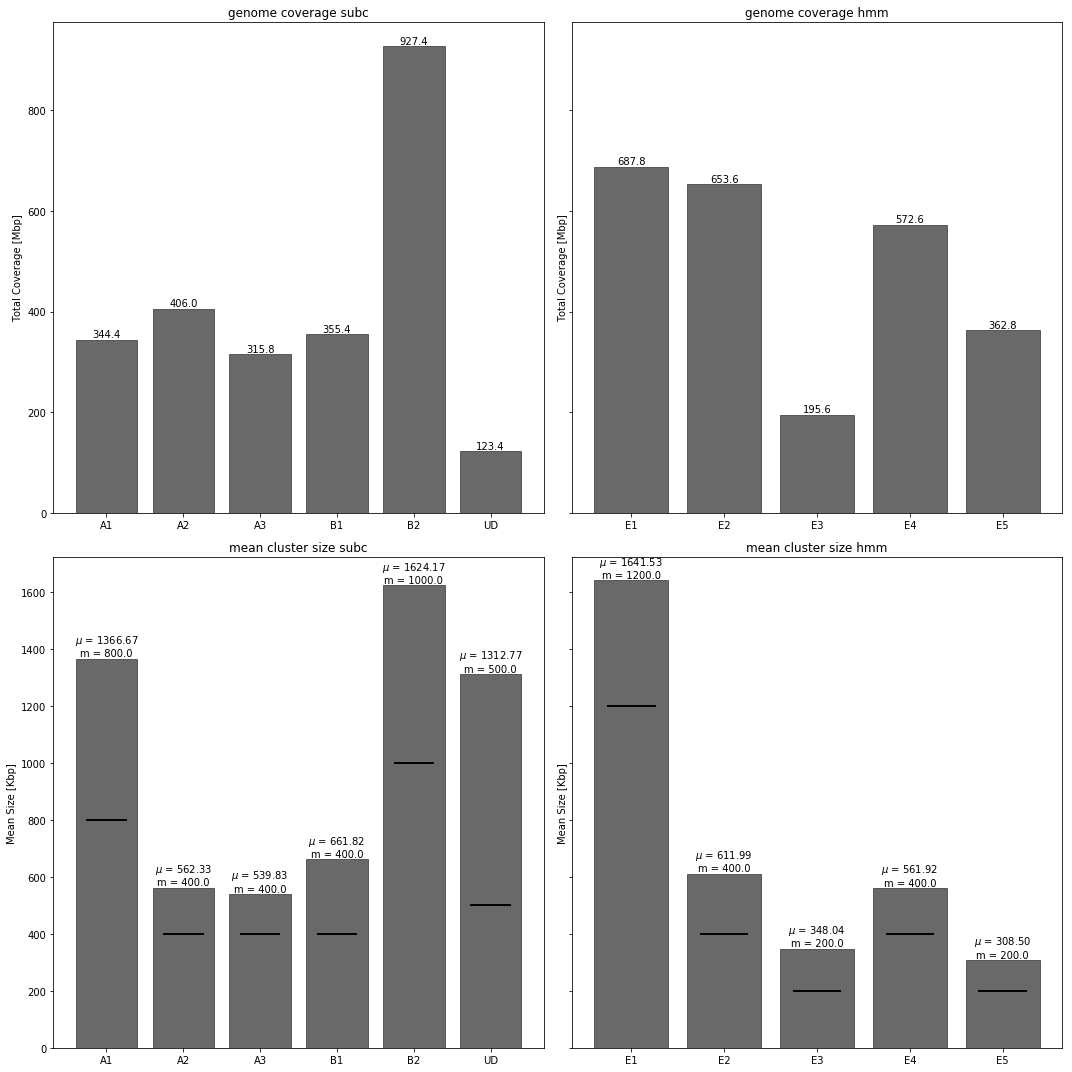

In [2]:
mat, indarr, chrlist = loadH5('CH12_HiC_200kb_EO.h5')
chrbins = computeBinsPerChrom(chrlist, indarr, mat.shape[0])
eigvtrackperchr = getGenomewideEigv(mat, chrlist, 'mm9_refseq.merged.bed', 200000, indarr)
sctrackperchr = readSegmentation('CH12_subcompartments.bed', 200000, chrbins)
hmmtrackperchr = readSegmentation('CH12_5_999_segments.bed', 200000, chrbins)
matshape = mat.shape[0]
del mat

#preparing segmentation tracks for plotting
clusterdict = {'subc': None, 'hmm': None}
mapIntToString = {'subc': None, 'hmm': None}
for k1, track in zip(['subc', 'hmm'], [sctrackperchr, hmmtrackperchr]):
    clusters = {'odd': None, 'even': None}
    intToString = {'odd': {}, 'even': {}}
    for k2, listOfChroms in zip(['even', 'odd'], 
                                [['chr2', 'chr4', 'chr6', 'chr8', 'chr10',
                                  'chr12', 'chr14', 'chr16', 'chr18'],
                                 ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 
                                  'chr11', 'chr13', 'chr15', 'chr17', 'chr19']]):
        tmp = np.concatenate([np.array(track[chr]) for chr in listOfChroms])
        clustertrack = np.zeros(shape = len(tmp), dtype = int)
        for i, c in enumerate(sorted(np.unique(tmp))):
            #print(i, c)
            clustertrack[tmp == c] = i
            intToString[k2][i] = c
        
        clusters[k2] = clustertrack
                  
    clusterdict[k1] = clusters
    mapIntToString[k1] = intToString

fig1, axs1 = plt.subplots(2, 2, sharey = 'row')
odd2even = {i: i for i in range(6)}
labels = {'subc': ['A1', 'A2', 'A3', 'B1', 'B2', 'UD'],
          'hmm': ['E1', 'E2', 'E3', 'E4', 'E5']}
for i, k in enumerate(['subc', 'hmm']):
    axarr = axs1[:, i]
    for ax, title, plotfunc in zip(axarr, 
                                   ['genome coverage', 'mean cluster size'], 
                                   [clusterCoverage, meanClusterSize]):
        plotfunc(clusterdict[k], odd2even, 200000, ax, labels[k])
        ax.set_title(title + ' ' + k)
    
fig1.set_figwidth(15)
fig1.set_figheight(15)
fig1.tight_layout()
fig1.savefig('clustercoverageandsize.pdf')

# Computing Spearman correlation of segments with A/B compartments

In order to get a feeling for the correlation of subcompartments and chromHMM segments we compute the Spearman correlation coefficient between each subcompartment/segment and the first eigenvector of the Hi-C matrix (i.e A/B compartment track). This is done by first generating dedicated tracks for each subcompartment/segment by setting all bins belonging to the currently examined subcompartment/segment to 1 and all other bins to -1 (e.g. assume we have a 10 bins subdivided into 3 clusters with following assignment aaaabbcccb then for each cluster in order to compute the Spearman correlation coefficient we would create a track like for b -1, -1, -1, 1, 1, -1, -1, -1, 1). Note that I used both identifiers (for subcompartments and chromHMM segments) as xtick labels in the heatmap, where A1,..., B2 is for the subc row and E1,..., E5 is for the hmm row, referring to Hi-C subcompartments and chromHMM segments, respectively.

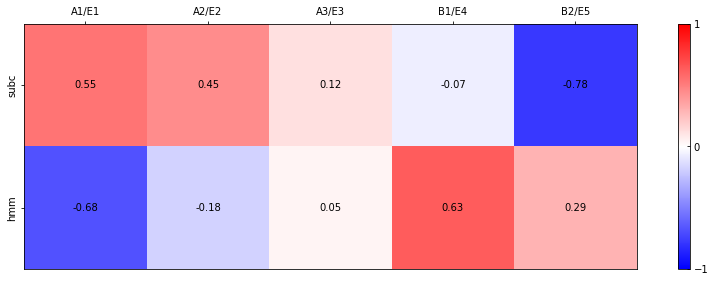

In [3]:
ABcorr = np.zeros(shape = (2, 5))
chrbins = computeBinsPerChrom(chrlist, indarr, matshape)
sctrack = np.concatenate([np.array(sctrackperchr[chr]) for chr in chrlist])
hmmtrack = np.concatenate([np.array(hmmtrackperchr[chr]) for chr in chrlist])
eigvtrack = np.concatenate([eigvtrackperchr[chr] for chr in chrlist])

ABcorr[0, :], p = correlateSegmentationWithEigv(sctrack, eigvtrack, labels['subc'][:-1])
ABcorr[1, :], p = correlateSegmentationWithEigv(hmmtrack, eigvtrack, labels['hmm'])

fig2, axs2 = plt.subplots()
plotheatmap(ABcorr, axs2, 'bwr', ['A1/E1', 'A2/E2', 'A3/E3', 'B1/E4', 'B2/E5'], 
            ['subc', 'hmm'], vmax = 1, vmin = -1, cbar = True, cbarticks = [1, 0, -1], reorder = False)

fig2.set_figwidth(12)
fig2.set_figheight(4)
fig2.tight_layout()

Here we clearly see a similar correspondence of the chromHMM segments with the A/B compartments as for the Hi-C subcompartments. Note that I did not make the effort to reorder the chromHMM segments accordingly.

# Computing Spearman correlation between Hi-C and chromHMM segmentation

Since the whole purpose of this analysis was to assess the correspondence of the genome segmentation by chromHMM and our Hi-C subcompartments, we compute the Spearman correlation coefficient between each pair of Hi-C subcompartments and chromHMM segements (i.e. A1/E1, A1/E2,..., B2/E5). This is done much in the same way as the correlation between A/B compartmeents and subcompartments/segments. First we generate a dedicated track for each subcompartment/segment setting all bins belonging to the examined subcompartment/segment to 1 and all others to -1 and then compute the Spearman correlation. The results are displayed in the heatmap below.

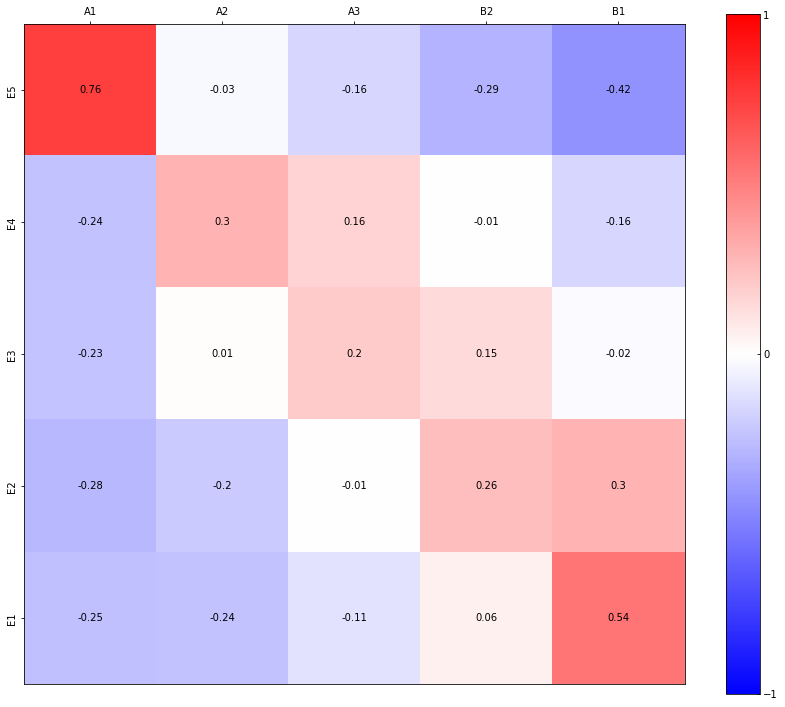

In [4]:
segcorr, p = correlateSegmentations(sctrack, hmmtrack, labels['subc'][:-1], labels['hmm'])

fig3, axs3 = plt.subplots()
plotheatmap(segcorr, axs3, 'bwr', labels['subc'][:-1], labels['hmm'],
            vmax = 1, vmin = -1, cbar = True, cbarticks = [1, 0, -1])

fig3.set_figwidth(12)
fig3.set_figheight(10)
fig3.tight_layout()

Although the correlation is only strong between A1/E5 and B1/E1 there is a good correspondence between the chromHMM segments and our Hi-C subcompartments, further validating our Hi-C subcompartments and strengthening the point that Hi-C can be used to subdivide the genome into different states of chromatin.

# Computing enrichment and correlation of segments with dedicated NGS data

In a last analysis, we compute the enrichment and Spearman correlation between Hi-C subcompartments and the used NGS data sets (same approach as in the Hi-C subcompartment analysis). Again, note that chromHMM segments are not sorted.

{'subc': ['A1', 'A2', 'A3', 'B1', 'B2', 'UD'], 'hmm': ['E1', 'E2', 'E3', 'E4', 'E5']}


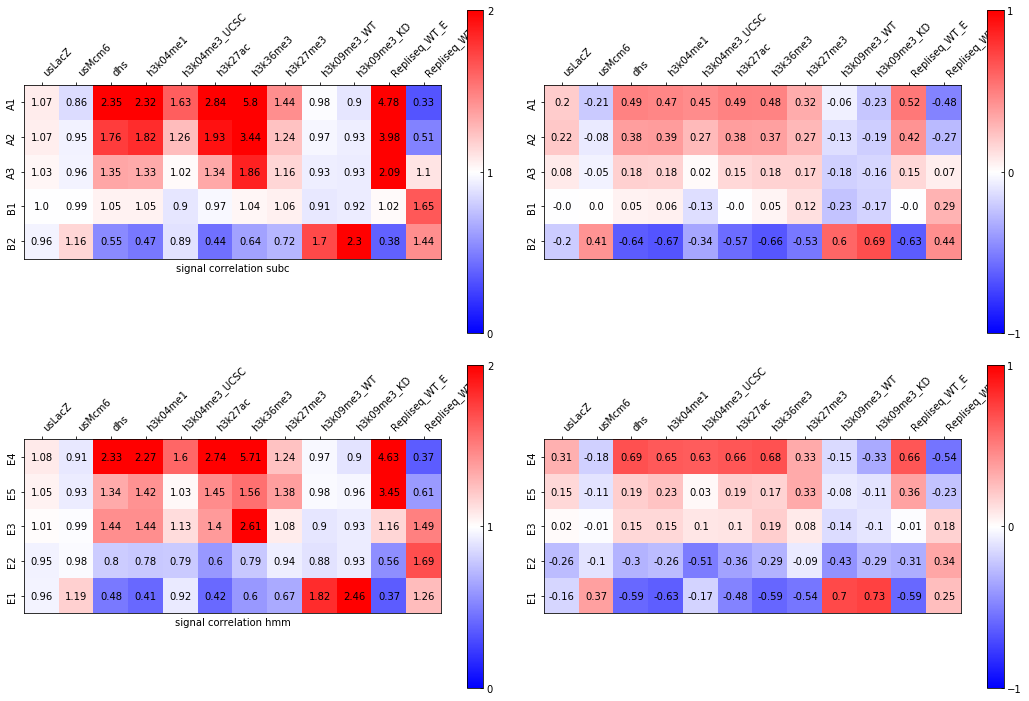

In [5]:
tracks = {'usLacZ': 'CH12_unstimulated_shLacZ_200000.bdg',
          'usMcm6': 'CH12_unstimulated_shMcm6_200000.bdg',
          'dhs': 'dhs_200000.bdg', 'h3k04me1': 'h3k04me1_200000.bdg', 
          'h3k04me3_UCSC': 'h3k04me3_200000.bdg', 
          'h3k27ac': 'h3k27ac_200000.bdg', 'h3k36me3': 'h3k36me3_200000.bdg',
          'h3k27me3': 'h3k27me3_200000.bdg', 
          'h3k09me3_WT': 'h3k09me3_WT_200000.bdg', 'h3k09me3_KD': 'h3k09me3_KD_200000.bdg', 
          'Repliseq_WT_E': 'repliseq_WT_E_200000.bdg',
          'Repliseq_WT_L': 'repliseq_WT_L_200000.bdg'
          #'Repliseq_KD_E': 'repliseq_KD_E_200000.bdg', 'Repliseq_KD_L': 'repliseq_KD_L_200000.bdg'
}

print(labels)
signaltracks = {k: readSignalTrack(os.path.join('signals', file), 
                                   200000, chrbins, chrlist) for k, file in tracks.items()}

enrichmentdict = {k: np.zeros(shape = (len(signaltracks), len(labels[k]))) for k in ['subc', 'hmm']}
correlationdict = {k: np.zeros(shape = (len(signaltracks), len(labels[k]))) for k in ['subc', 'hmm']}
corrpvalsdict = {k: np.zeros(shape = (len(signaltracks), len(labels[k]))) for k in ['subc', 'hmm']}
tracklabels = []

for k, clustertrack in zip(['subc', 'hmm'], [sctrack, hmmtrack]):
    intclustertrack = np.zeros(shape = len(clustertrack), dtype = int)
    for i, c in enumerate(np.unique(clustertrack)):
        intclustertrack[clustertrack == c] = i
        
    for i, (name, track) in enumerate(signaltracks.items()):
        enrichmentdict[k][i, :] = enrichSignal(track, intclustertrack, False)
        correlationdict[k][i, :], corrpvalsdict[k][i, :] = correlateSignal(track, intclustertrack, False)
        tracklabels.append(name)

tracklabels = removeDuplicates(tracklabels)
fig4, axs4 = plt.subplots(2, 2)
for i, k in enumerate(['subc', 'hmm']):
    ax1, ax2 = axs4[i, :]
    enrichplotmat = enrichmentdict[k][:, :-1].T if k == 'subc' else enrichmentdict[k].T
    corrplotmat = correlationdict[k][:, :-1].T if k == 'subc' else correlationdict[k].T
    yorder = None if k == 'subc' else [3, 4, 2, 1, 0]
    xorder = None if k == 'subc' else range(enrichplotmat.shape[1])
    plotlabels = labels[k][:-1] if k == 'subc' else labels[k]
    

    plotheatmap(enrichplotmat, ax1, 'bwr', tracklabels, plotlabels, vmin = 0, 
            vmax = 2, reorder = False, yorder = yorder, xorder = xorder,
            cbar = True, cbarticks = [0, 1, 2], xrotation = 45)
    ax1.set_xlabel('signal enrichment' + ' ' + k)
    
    plotheatmap(corrplotmat, ax2, 'bwr', tracklabels, plotlabels, vmin = -1, 
                vmax = 1, reorder = False, yorder = yorder, xorder = xorder, cbar = True, 
                cbarticks = [-1, 0, 1], xrotation = 45)
    ax1.set_xlabel('signal correlation' + ' ' + k)

fig4.set_figwidth(15)
fig4.set_figheight(10)
fig4.tight_layout()
fig4.savefig('enrichcorr.pdf')

The results of these analysis is quite comparable for Hi-C subcompartments and chromHMM further strengthening our point.